In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import make_pipeline
from DataProcessing import *
from FeatureEngineering import *


C:\Users\Jeffrey Tsai\Anaconda3\lib\site-packages\sklearn\utils\fixes.py:313: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  _nan_object_mask = _nan_object_array != _nan_object_array


In [2]:
class Estimator:
    def __init__(self,train_df=None,Xtest_df=None,response_name=None,folds=None,
                 modelList=None,lossDict=None,lossStdDict=None):
        '''
        init method for salary linear estimation
        '''
        self.train_df = train_df
        self.Xtest_df = Xtest_df
        # split X features and reponse from train df
        self.Xtrain_df = self.train_df.drop(response_name,axis=1)
        self.folds = folds
        self.ytrain_df = self.train_df[response_name]
        self.modelList = modelList
        self.lossDict = lossDict
        self.lossStdDict = lossStdDict

    def _baseline_estimator(self,figsz=(10,6)):
        '''
        define naive baseline estimator as mean salary
        '''
        mean_ytrain = np.mean(self.ytrain_df)
        # assign constant ndarray 
        self.yhat_train_baseline = np.full(shape=(len(self.ytrain_df),1),fill_value=mean_ytrain)
        devs_train_baseline = self.ytrain_df - self.yhat_train_baseline
        self.mse_train_baseline = np.mean(np.square(devs_train_baseline))
        self.rmse_train_baseline = np.sqrt(self.mse_train_baseline)
        print('mse_sk:',mean_squared_error(self.ytrain_df,self.yhat_train_baseline))
        print('rmse_sk:',np.sqrt(mean_squared_error(self.ytrain_df,self.yhat_train_baseline)))

    def plot_loss(self,hyper_arr=None,train_loss_arr=None,val_loss_arr=None,figsz=(10,6),xlabel=None,ylabel=None,folds=None):
        '''
        visualize loss in loss_arr at each hyperparameter in hyper_arr
        '''
        f,ax = plt.subplots(figsize=figsz)
        ax.plot(hyper_arr,train_loss_arr,color='blue',label='train')
        ax.plot(hyper_arr,val_loss_arr,color='red',label='validation')
        ax.set(title='{}-Fold Cross-Validation Loss'.format(folds),xlabel=xlabel,ylabel=ylabel)
        ax.legend()#(loc='upper_left')
        
    def _tune_hyperparams(self,model=None,params=None,lossfunc='neg_mean_squared_error',figsz=(10,6),ylabel='MSE',plot_param='randomforestregressor__n_estimators'):
        '''
        method to tune model hyperparameters with GridSearchCV
        '''
        gs = GridSearchCV(model,param_grid=params,cv=self.folds,
                         scoring=lossfunc,return_train_score=True)
        gs.fit(self.Xtrain_df,self.ytrain_df)
        best_model = gs.best_estimator_
        best_score = gs.best_score_
        best_test_score_array = gs.cv_results_['mean_test_score']
        if lossfunc=='neg_mean_squared_error':
            best_score = -1.0*best_score
            best_test_score_array = -1.0*best_test_score_array
            scores_train = -1.0*gs.cv_results_['mean_train_score']
            scores_val = -1.0*gs.cv_results_['mean_test_score']
        else:
            best_score = best_score
            best_test_score_array = best_test_score_array
            scores_train = gs.cv_results_['mean_train_score']
            scores_val = gs.cv_results_['mean_test_score']
        print('scores_train:',scores_train)
        print('scores_val:',scores_val)
        print('tuned optimal hyperparmeter:',gs.best_params_)   
        print('gridsearch best score:',best_score)
        # viz loss vs. hyperparameters
        xs = params[plot_param]
        self.plot_loss(hyper_arr=xs,train_loss_arr=scores_train,val_loss_arr=scores_val,
                           figsz=figsz,xlabel=plot_param,ylabel=ylabel,folds=self.folds)
        # return hyperparameter search best model:    
        return best_model 

#### Instantiate data object $data$

In [3]:
ordinalcodes = {'degree':{'NONE':0,'HIGH_SCHOOL':1,'BACHELORS':2,'MASTERS':3,
                          'DOCTORAL':4},
                'jobType':{'JANITOR':0,'JUNIOR':1,'SENIOR':2,'MANAGER':3,
                           'VICE_PRESIDENT':4,'CFO':5,'CTO':6,'CEO':7},
#                 'industry':{'EDUCATION':0,'SERVICE':1,'AUTO':2,'HEALTH':3,'WEB':4,'FINANCE':5,'OIL':6}
#                 'major':{'NONE':0,'LITERATURE':1,'BIOLOGY':2,'CHEMISTRY':3,
#                          'PHYSICS':4,'COMPSCI':5,'MATH':6,'BUSINESS':7,'ENGINEERING':8},
               }


# from DataProcessing import * 
data = Data(fname_Xtrain='train_features.csv',fname_ytrain='train_salaries.csv',
         fname_Xtest='test_features.csv',
         columns_cat=['companyId','degree','industry','jobType','major'],
         columns_num=['milesFromMetropolis','yearsExperience'],
         ylabel='salary',joinId='jobId',ordinal_dict=ordinalcodes)

# train_df = data._encode_categorical_features(data.train_df,ordinal_dict=None,nominal_cols=['companyId','industry','jobType'])    
# train_df = data._preprocessData(data.train_df,clean=True,encode=True,nominal_cols=['companyId','degree','industry','major','jobType'])
vec_train_df = data._preprocessData(data.train_df,clean=True,encode=True,nominal_cols=['companyId','industry','major'])
train_df = data._preprocessData(data.train_df,clean=True,encode=True,nominal_cols=['companyId','industry','major'])
train_df.head()

,milesFromMetropolis,yearsExperience,jobId,salary,companyId,industry,major,jobType,degree
0,83,10,JOB1362684407687,130,31,3,6,5,3
1,73,3,JOB1362684407688,101,11,6,7,7,1
2,38,10,JOB1362684407689,137,48,3,8,4,4
3,17,8,JOB1362684407690,142,32,0,2,3,4
4,16,8,JOB1362684407691,163,60,2,8,4,2


#### Instantiate feature engineering object and compute grouped statistics as new features   

In [4]:
featureEng = FeatureEng(data_object=data) 
train_df = featureEng._compute_new_features(train_df,train_df,cat_columns=featureEng.data.columns_cat,
                                            num_columns=featureEng.data.columns_num,qcuts=4)
train_df.head()

,milesFromMetropolis,yearsExperience,jobId,salary,companyId,industry,major,jobType,degree,cat_group_min,...,cat_group_mean,cat_group_max,cat_group_std,milesFromMetropolis_quantile,yearsExperience_quantile,numeric_quantile_min,numeric_quantile_median,numeric_quantile_mean,numeric_quantile_max,numeric_quantile_std
0,83,10,JOB1362684407687,130,31,3,6,5,3,98,...,130.875000,150,19.555324,3,1,24,100,101.458150,235,40.570867
1,73,3,JOB1362684407688,101,11,6,7,7,1,90,...,138.031250,204,29.306248,2,0,19,97,98.533393,237,40.565094
2,38,10,JOB1362684407689,137,48,3,8,4,4,116,...,142.000000,173,28.827071,1,1,34,117,118.812494,260,42.080528
3,17,8,JOB1362684407690,142,32,0,2,3,4,77,...,129.000000,169,29.251781,0,1,39,127,128.265325,282,43.126252
4,16,8,JOB1362684407691,163,60,2,8,4,2,94,...,153.583333,232,46.310137,0,1,39,127,128.265325,282,43.126252


#### Instantiate estimator object $m$

In [5]:
m = Estimator(train_df=shuffle(train_df[:50000]).drop(data.id,axis=1),Xtest_df=data.Xtest_df,response_name=data.ylabel,
              folds=5,modelList=[],lossDict={},lossStdDict={})

## RandomForestRegressor

#### Tune RandomForest *n_estimators* hyperparameter
- *n_estimators* is the number of trees in the forest
- the estimator becomes more flexible as *n_estimators* increases
- optimal *n_estimators* hyperparameter is around 50.

scores_train: [ 48.1337526]
scores_val: [ 339.62414931]
tuned optimal hyperparmeter: {'randomforestregressor__n_estimators': 70}
gridsearch best score: 339.624149314


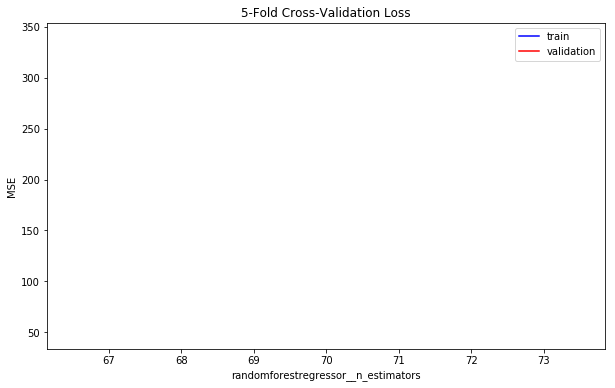

In [7]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[70],#[2,50,100], #70:339
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__n_estimators')   


#### Tune RandomForest *max_depth* hyperparameter:
- *max_depth* hyperparameter is the maximum depth of the tree; if *None*, then nodes are expanded until all leaves are pure or until all leaves contain less than *min_samples_split* samples 
- optimal search returned  minimum validation loss at *max_depth* value around 10

scores_train: [ 655.8328222   503.06801445  424.70067016  374.34877196  346.97722927
  326.9872464   307.93196268  285.13838705  257.99165119  227.06429879
  194.96839133  163.68433347]
scores_val: [ 658.33135171  506.36063295  429.14092614  381.60493792  356.74943748
  343.2330903   335.97551946  330.97635065  329.10787045  328.6601747
  329.02944154  330.53690913]
tuned optimal hyperparmeter: {'randomforestregressor__max_depth': 11, 'randomforestregressor__n_estimators': 70}
gridsearch best score: 328.660174695


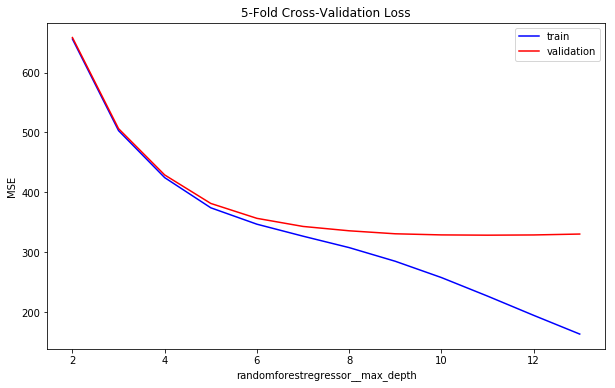

In [8]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[70], 
                                                         'randomforestregressor__max_depth':np.arange(2,14,1),  
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__max_depth') 

#### Tune RandomForest *min_samples_split* hyperparameter:
- *min_samples_split* hyperparameter is the minimum number of samples required to split an internal node.
- smaller values of *min_samples_split* results in a more flexible estimator 
- optimal search returned minimum validation loss at *min_samples_split* value around 40

scores_train: [ 234.4401627   245.234362    253.86068799  260.80498487  266.80597662
  271.77451134  276.25188578  280.19583413]
scores_val: [ 328.41579908  327.77310276  327.74098682  327.45749452  327.9182461
  328.34506095  328.56402227  328.63526147]
tuned optimal hyperparmeter: {'randomforestregressor__max_depth': 11, 'randomforestregressor__n_estimators': 70, 'randomforestregressor__min_samples_split': 40}
gridsearch best score: 327.457494517


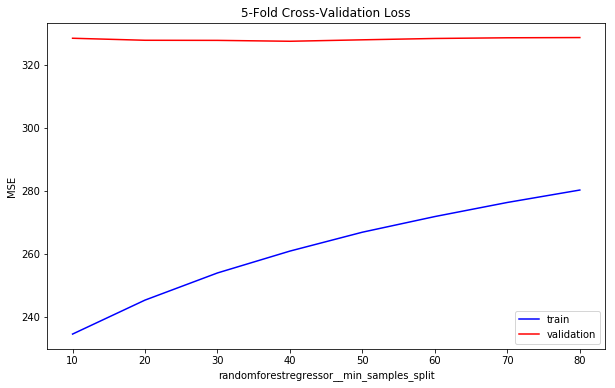

In [9]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[70], 
                                                         'randomforestregressor__max_depth':[11],  
                                                         'randomforestregressor__min_samples_split':np.arange(10,81,10), #60:319
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__min_samples_split') 

#### Tune RandomForest *min_samples_leaf* hyperparameter
- *min_samples_leaf* hyperparameter is the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least *min_samples_leaf* training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
- Smaller values of *min_samples_leaf* results in a more flexible estimator.
- GridSearch returned minimum validation loss at around *min_samples_leaf* value of 25.

scores_train: [ 260.68792379  280.14258861  302.00913696  314.49363263]
scores_val: [ 327.69208543  327.09756814  331.94954127  336.36000148]
tuned optimal hyperparmeter: {'randomforestregressor__max_depth': 11, 'randomforestregressor__min_samples_leaf': 26, 'randomforestregressor__n_estimators': 70, 'randomforestregressor__min_samples_split': 40}
gridsearch best score: 327.097568138


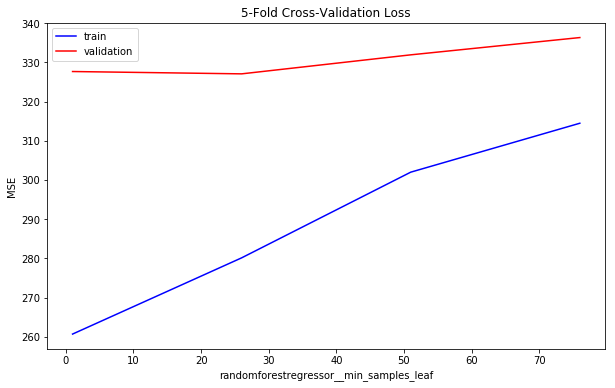

In [11]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[70], 
                                                         'randomforestregressor__max_depth':[11],  
                                                         'randomforestregressor__min_samples_split':[40], 
                                                         'randomforestregressor__min_samples_leaf':np.arange(1,101,25), 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__min_samples_leaf') 

#### Tune RandomForest *min_weight_fraction_leaf* hyperparameter
- *min_weight_fraction_Leaf* hyperparameter is the minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when sample_weight is not provided.
- A lower *min_weight_fraction_leaf* value results in a more flexible model.
- GridSearch returned a minimum validation loss at the default value of *min_weight_fraction_leaf*=0.


scores_train: [ 278.90253281  350.64901908  509.02414549]
scores_val: [ 327.35855106  359.44402692  512.24684996]
tuned optimal hyperparmeter: {'randomforestregressor__max_depth': 11, 'randomforestregressor__min_samples_leaf': 25, 'randomforestregressor__n_estimators': 70, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__min_samples_split': 40}
gridsearch best score: 327.35855106


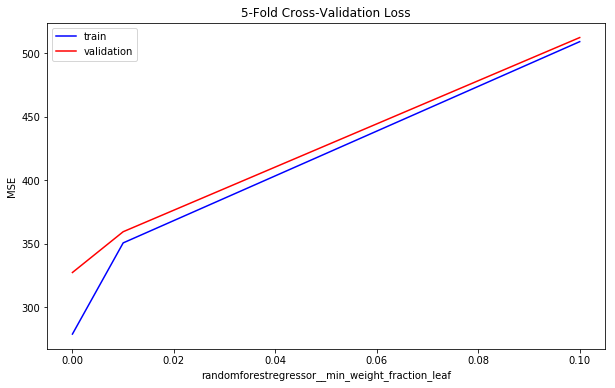

In [12]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[70], 
                                                         'randomforestregressor__max_depth':[11],  
                                                         'randomforestregressor__min_samples_split':[40], 
                                                         'randomforestregressor__min_samples_leaf':[25], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0,1e-2,0.1], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__min_weight_fraction_leaf') 

#### Tune RandomForest *max_features* hyperparameter:
- max_features hyperparameter is the number of
- GridSearch returned minimum validation loss at around *max_features* value 0.875

scores_train: [ 330.48532488  331.00087553  308.98821952  301.21271377  297.04684875
  289.6902993   286.69704249  284.46279237  283.55628625  281.72311449
  280.33626518  279.47065133]
scores_val: [ 357.96992011  358.73482992  338.47859877  333.33072284  331.0835517
  329.24679603  328.29491458  327.9180387   327.38514762  327.53482619
  327.10569796  327.50986767]
tuned optimal hyperparmeter: {'randomforestregressor__min_samples_leaf': 25, 'randomforestregressor__n_estimators': 70, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__max_depth': 11, 'randomforestregressor__max_features': 0.875, 'randomforestregressor__min_samples_split': 40}
gridsearch best score: 327.10569796


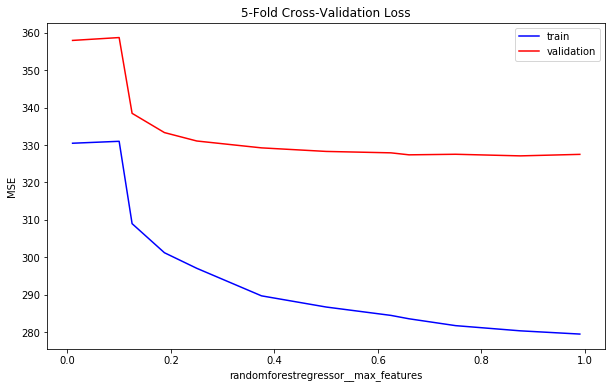

In [14]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[70], 
                                                         'randomforestregressor__max_depth':[11],  
                                                         'randomforestregressor__min_samples_split':[40], 
                                                         'randomforestregressor__min_samples_leaf':[25], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0], 
                                                         'randomforestregressor__max_features':[.01,.1,.125,.1875,.25,.375,.5,.625,.66,.75,.875,.99], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__max_features') 

#### Tune RandomForest hyperparameter *max_leaf_nodes*
- *max_leaf_nodes* hyperparameter will grow trees with *max_leaf_nodes* in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
- GridSearch returned minimum loss at *max_leaf_nodes*=*None*

scores_train: [ 468.40319414  328.65572058  328.94551531  275.59030713  280.27379554]
scores_val: [ 471.95491204  343.5599828   343.81535812  327.12881717  327.37019089]
tuned optimal hyperparmeter: {'randomforestregressor__min_samples_leaf': 25, 'randomforestregressor__n_estimators': 70, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__max_depth': 11, 'randomforestregressor__max_leaf_nodes': 10000, 'randomforestregressor__max_features': 0.875, 'randomforestregressor__min_samples_split': 40}
gridsearch best score: 327.128817165


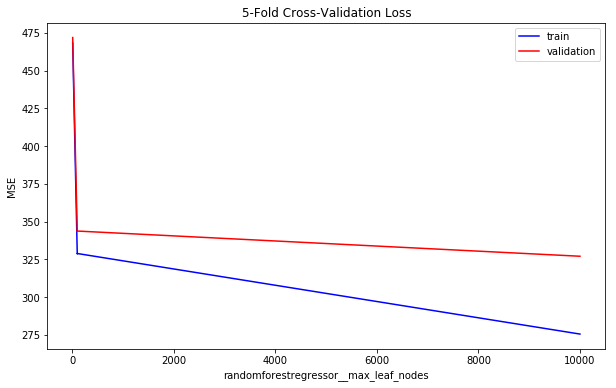

In [15]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[70], 
                                                         'randomforestregressor__max_depth':[11],  
                                                         'randomforestregressor__min_samples_split':[40], 
                                                         'randomforestregressor__min_samples_leaf':[25], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0], 
                                                         'randomforestregressor__max_features':[.875], 
                                                         'randomforestregressor__max_leaf_nodes':[10,100,100,10000,None], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__max_leaf_nodes') 

#### Tune RandomForest *min_impurity_decrease* hyperparameter
- *min_impurity_decrease* specifies when a node will be split if this split induces a decrease of the impurity greater than or equal to this value.
- a smaller value of *min_impurity_decrease* specifies a more flexible estimator.
- GridSearch returned minimal validation loss with *min_impurity_decrease*=0.

scores_train: [ 280.41569206  294.93351818  336.59584556]
scores_val: [ 327.48440697  330.40853536  349.06215196]
tuned optimal hyperparmeter: {'randomforestregressor__min_samples_leaf': 25, 'randomforestregressor__n_estimators': 70, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__max_depth': 11, 'randomforestregressor__min_impurity_decrease': 0, 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__max_features': 0.875, 'randomforestregressor__min_samples_split': 40}
gridsearch best score: 327.484406974


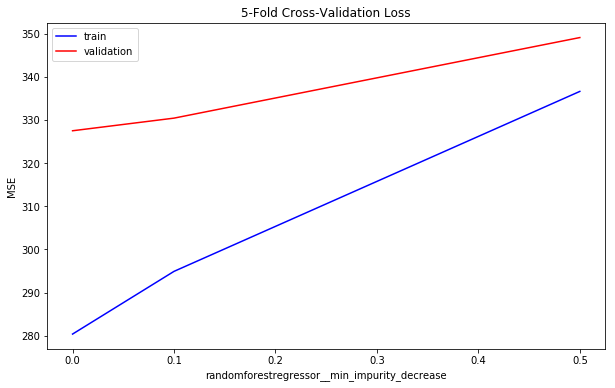

In [16]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[70], 
                                                         'randomforestregressor__max_depth':[11],  
                                                         'randomforestregressor__min_samples_split':[40], 
                                                         'randomforestregressor__min_samples_leaf':[25], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0], 
                                                         'randomforestregressor__max_features':[.875], 
                                                         'randomforestregressor__max_leaf_nodes':[None], 
                                                         'randomforestregressor__min_impurity_decrease':[0,.1,.5], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__min_impurity_decrease') 

#### Tune RandomForest hyperparameter *bootstrap*
- *bootstrap* hyperparameter specifies whether bootstrap samples are used when building trees. If False, the whole datset is used to build each tree.
- bootstrapped samples are preferred when building trees in the random forest
- We'll use the final hyperparameters specified below for RandomForestRegressor

scores_train: [ 280.38625575  271.37165613]
scores_val: [ 327.41472418  338.39616742]
tuned optimal hyperparmeter: {'randomforestregressor__min_samples_leaf': 25, 'randomforestregressor__n_estimators': 70, 'randomforestregressor__min_weight_fraction_leaf': 0, 'randomforestregressor__max_depth': 11, 'randomforestregressor__min_impurity_decrease': 0, 'randomforestregressor__max_leaf_nodes': None, 'randomforestregressor__bootstrap': True, 'randomforestregressor__min_samples_split': 40, 'randomforestregressor__max_features': 0.875}
gridsearch best score: 327.414724177


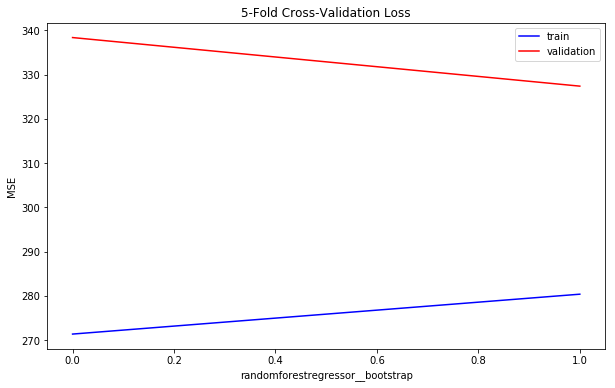

In [17]:
rf_pipe = make_pipeline(SimpleImputer(strategy='median'),RandomForestRegressor())
rf_pipe_best = m._tune_hyperparams(model=rf_pipe,params={
                                                         'randomforestregressor__n_estimators':[70], 
                                                         'randomforestregressor__max_depth':[11],  
                                                         'randomforestregressor__min_samples_split':[40], 
                                                         'randomforestregressor__min_samples_leaf':[25], 
                                                         'randomforestregressor__min_weight_fraction_leaf':[0], 
                                                         'randomforestregressor__max_features':[.875], 
                                                         'randomforestregressor__max_leaf_nodes':[None], 
                                                         'randomforestregressor__min_impurity_decrease':[0], 
                                                         'randomforestregressor__bootstrap':[True,False], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='randomforestregressor__bootstrap') 

## GradientBoostingRegressor

#### Tune GradientBoostingRegressor *learning_rate* hyperparameter
- *learning_rate* shrinks the contribution of each tree by the *learning_rate*. There is a trade-off between *learning_rate* and *n_estimators*.
- optimal *learning_rate* is somewhere around 0.20

scores_train: [ 329.54451731  312.50956642  307.55297018  307.15858305  294.90364332]
scores_val: [ 336.99412759  324.47288068  322.42697771  322.98407197  324.30674343]
tuned optimal hyperparmeter: {'gradientboostingregressor__learning_rate': 0.1875}
gridsearch best score: 322.426977714


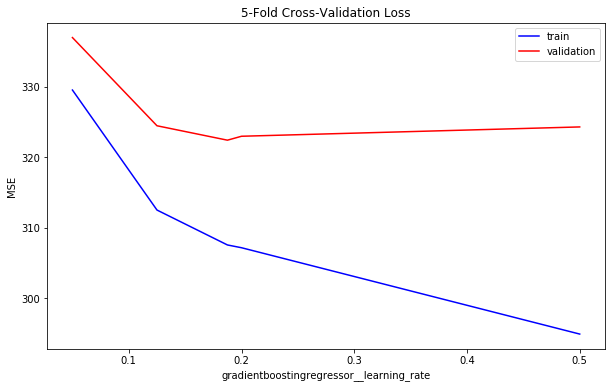

In [18]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.05,.125,.1875,.2,.5],
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__learning_rate') 

#### Tune GradientBoostingRegressor *n_estimators* hyperparameter
- *n_estimators* is the number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
- GridSearch found optimal *n_estimators* value around 250.

scores_train: [ 938.38405252  308.00797966  296.39968099  292.05123891  288.25291934]
scores_val: [ 940.7845573   321.97775612  319.4488788   319.39642838  319.51023356]
tuned optimal hyperparmeter: {'gradientboostingregressor__learning_rate': 0.1875, 'gradientboostingregressor__n_estimators': 250}
gridsearch best score: 319.396428378


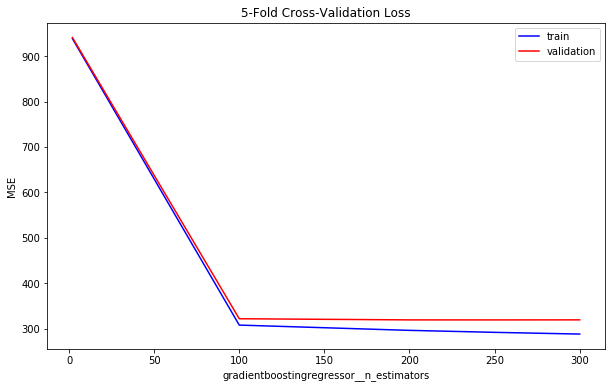

In [6]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.1875],
                                                         'gradientboostingregressor__n_estimators':[2,100,200,250,300],
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__n_estimators') 

#### Tune GradientBoostingRegressor *subsample* hyperparameter
- *subsample* controls the fraction of samples to be used for fitting the individual base learners. If smaller than 1.0 this results in Stochastic Gradient Boosting. *subsample* interacts with the parameter *n_estimators*. Choosing subsample < 1.0 leads to a reduction of variance and an increase in bias.
- GridSearch returned optimal *subsample* value of 1 (no variance regulation)

scores_train: [ 469.58458227  292.90449712  292.05123891]
scores_val: [ 495.96986744  322.58838366  319.44100477]
tuned optimal hyperparmeter: {'gradientboostingregressor__learning_rate': 0.1875, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__n_estimators': 250}
gridsearch best score: 319.44100477


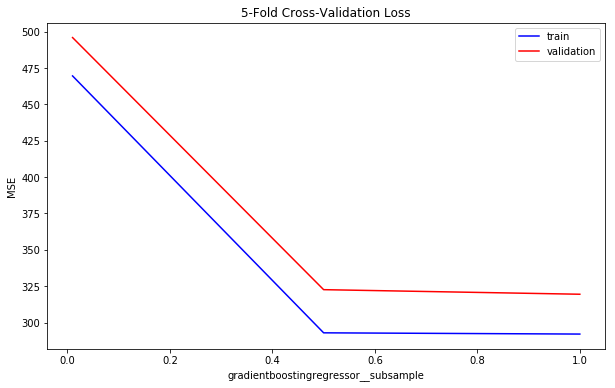

In [7]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.1875],
                                                         'gradientboostingregressor__n_estimators':[250],
                                                         'gradientboostingregressor__subsample':[.01,.5,1],
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__subsample') 

#### Tune GradientBoostingRegressor *min_samples_split* hyperparameter
- The minimum number of samples required to split an internal node: If *int*, then consider *min_samples_split* as the minimum number. If *float*, then *min_samples_split* is a fraction and *ceil(min_samples_split * n_samples)* are the minimum number of samples for each split.
- Minimal validation loss was maintained with *min_samples_split* value of 3. 

scores_train: [ 292.05123891  292.05018499  292.21111869]
scores_val: [ 319.44534478  319.0785365   319.20139362]
tuned optimal hyperparmeter: {'gradientboostingregressor__learning_rate': 0.1875, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__min_samples_split': 3, 'gradientboostingregressor__n_estimators': 250}
gridsearch best score: 319.078536502


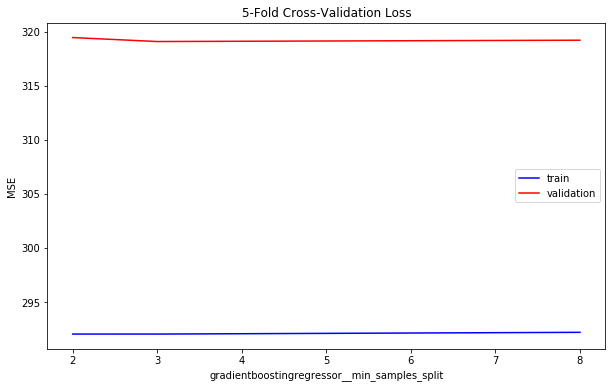

In [8]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.1875],
                                                         'gradientboostingregressor__n_estimators':[250],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[2,3,8],
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__min_samples_split') 

#### Tune GradientBoostingRegressor *min_samples_leaf* hyperparameter
- *min_samples_leaf* hyperparameter is the minimum number of samples required to be at a leaf node. A split point at any depth will only be considered if it leaves at least *min_samples_leaf* training samples in each of the left and right branches. This may have the effect of smoothing the model, especially in regression.
- GridSearch returned minimal validation loss at arond *min_samples_leaf*=500. 

scores_train: [ 291.97745359  297.42566782  298.76484969  299.77630695  300.47530674]
scores_val: [ 318.98930261  317.75663587  317.49603699  317.3715812   317.62818609]
tuned optimal hyperparmeter: {'gradientboostingregressor__learning_rate': 0.1875, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__min_samples_split': 3, 'gradientboostingregressor__n_estimators': 250, 'gradientboostingregressor__min_samples_leaf': 500}
gridsearch best score: 317.371581204


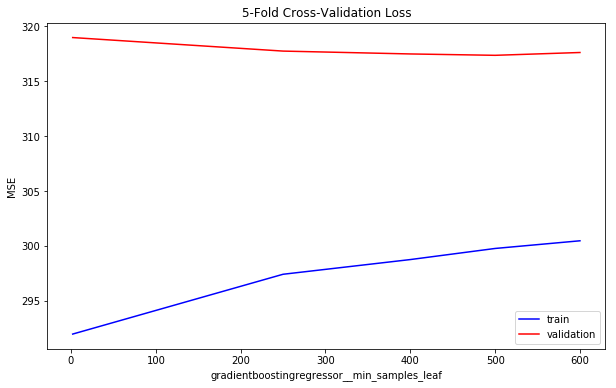

In [13]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.1875],
                                                         'gradientboostingregressor__n_estimators':[250],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[3],
                                                         'gradientboostingregressor__min_samples_leaf':[2,250,400,500,600], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__min_samples_leaf') 

#### Tune GradientBoostingRegressor *min_weight_fraction_leaf*
- Hyperparameter *min_weight_fraction_leaf* is the minimum weighted fraction of the sum total of weights (of all the input samples) required to be at a leaf node. Samples have equal weight when *sample_weight* is not provided.
- The *min_weigh_fraction_leaf* default value of zero is optimal. 

scores_train: [  299.77630695   299.77630695  1261.30715775]
scores_val: [  317.3715812   317.3715812  1264.284955 ]
tuned optimal hyperparmeter: {'gradientboostingregressor__learning_rate': 0.1875, 'gradientboostingregressor__min_weight_fraction_leaf': 0, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__min_samples_leaf': 500, 'gradientboostingregressor__min_samples_split': 3, 'gradientboostingregressor__n_estimators': 250}
gridsearch best score: 317.371581204


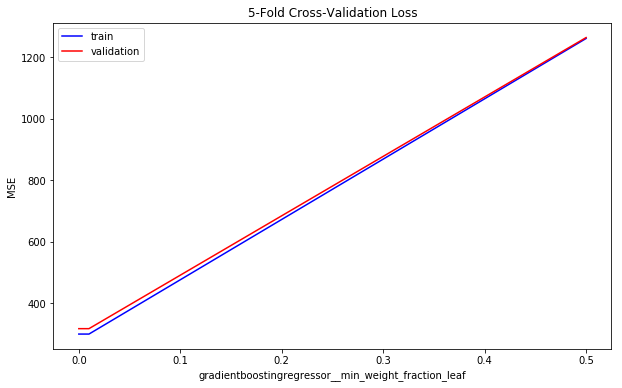

In [14]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.1875],
                                                         'gradientboostingregressor__n_estimators':[250],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[3],
                                                         'gradientboostingregressor__min_samples_leaf':[500], 
                                                         'gradientboostingregressor__min_weight_fraction_leaf':[0,.01,.5], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__min_weight_fraction_leaf') 

#### Tune GradientBoostingRegressor *max_depth* hyperparameter
- *max_depth* specifies the maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. The best value depends on the interaction of the input variables.
- GridSearch determined optimal *max_depth* value is 3.

scores_train: [ 313.45583434  299.77630695  288.340912    277.69496443]
scores_val: [ 323.00298453  317.3715812   317.8984576   318.10712236]
tuned optimal hyperparmeter: {'gradientboostingregressor__learning_rate': 0.1875, 'gradientboostingregressor__min_weight_fraction_leaf': 0, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__min_samples_leaf': 500, 'gradientboostingregressor__min_samples_split': 3, 'gradientboostingregressor__n_estimators': 250, 'gradientboostingregressor__max_depth': 3}
gridsearch best score: 317.371581204


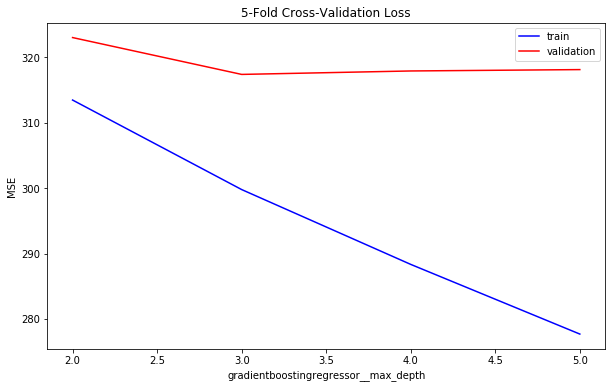

In [16]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.1875],
                                                         'gradientboostingregressor__n_estimators':[250],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[3],
                                                         'gradientboostingregressor__min_samples_leaf':[500], 
                                                         'gradientboostingregressor__min_weight_fraction_leaf':[0], 
                                                         'gradientboostingregressor__max_depth':np.arange(2,6,1), 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__max_depth') 

#### Tune GradientBoostingRegressor *min_impurity_decrease* hyperparameter
- *min_impurity_decrease* specifies when a node will be split if this split induces a decrease of the impurity greater than or equal to this value.
- GridSearch determined the optimal *min_impurity_decrease* value was zero. 

scores_train: [ 299.77630695  299.77630695  299.77630695]
scores_val: [ 317.3715812  317.3715812  317.3715812]
tuned optimal hyperparmeter: {'gradientboostingregressor__learning_rate': 0.1875, 'gradientboostingregressor__min_weight_fraction_leaf': 0, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__min_samples_leaf': 500, 'gradientboostingregressor__min_impurity_decrease': 0, 'gradientboostingregressor__min_samples_split': 3, 'gradientboostingregressor__n_estimators': 250, 'gradientboostingregressor__max_depth': 3}
gridsearch best score: 317.371581204


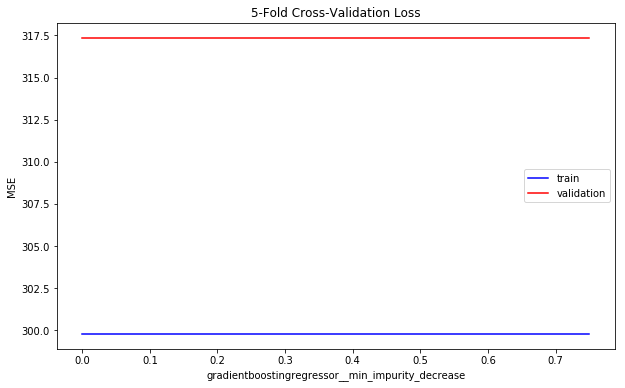

In [17]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.1875],
                                                         'gradientboostingregressor__n_estimators':[250],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[3],
                                                         'gradientboostingregressor__min_samples_leaf':[500], 
                                                         'gradientboostingregressor__min_weight_fraction_leaf':[0], 
                                                         'gradientboostingregressor__max_depth':[3], 
                                                         'gradientboostingregressor__min_impurity_decrease':[0,.25,.75], 
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__min_impurity_decrease') 

#### Tune GradientBoostingRegressor hyperparameter *max_features*
- *max_features* specifies the number of features to consider when looking for the best split. Choosing *max_features* < *n_features* leads to a reduction of variance and an increase in bias
- GridSearch optimal *max_features* value was the default sklearn value *None*, i.e. using *max_features=n_estimators*.

scores_train: [ 319.04333248  301.24046951  299.77630695]
scores_val: [ 330.87389385  317.9822107   317.3715812 ]
tuned optimal hyperparmeter: {'gradientboostingregressor__learning_rate': 0.1875, 'gradientboostingregressor__min_weight_fraction_leaf': 0, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__min_samples_leaf': 500, 'gradientboostingregressor__min_impurity_decrease': 0, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 250, 'gradientboostingregressor__min_samples_split': 3}
gridsearch best score: 317.371581204


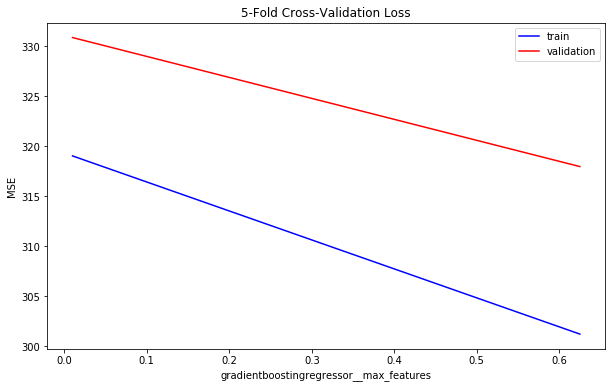

In [18]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.1875],
                                                         'gradientboostingregressor__n_estimators':[250],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[3],
                                                         'gradientboostingregressor__min_samples_leaf':[500], 
                                                         'gradientboostingregressor__min_weight_fraction_leaf':[0], 
                                                         'gradientboostingregressor__max_depth':[3], 
                                                         'gradientboostingregressor__min_impurity_decrease':[0], 
                                                         'gradientboostingregressor__max_features':[.01,.625,None],  
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__max_features') 

#### Tune GradientBoostingRegressor hyperparameter *max_leaf_nodes*
- Grow trees with *max_leaf_nodes* in best-first fashion. Best nodes are defined as relative reduction in impurity. If None then unlimited number of leaf nodes.
- GridSearch found the default sklearn *max_leaf_nodes* value of *None* as optimal

scores_train: [ 348.71086191  288.340912    288.340912    299.77630695]
scores_val: [ 352.58001834  317.8984576   317.8984576   317.3715812 ]
tuned optimal hyperparmeter: {'gradientboostingregressor__learning_rate': 0.1875, 'gradientboostingregressor__min_weight_fraction_leaf': 0, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__min_impurity_decrease': 0, 'gradientboostingregressor__min_samples_leaf': 500, 'gradientboostingregressor__max_leaf_nodes': None, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 250, 'gradientboostingregressor__min_samples_split': 3}
gridsearch best score: 317.371581204


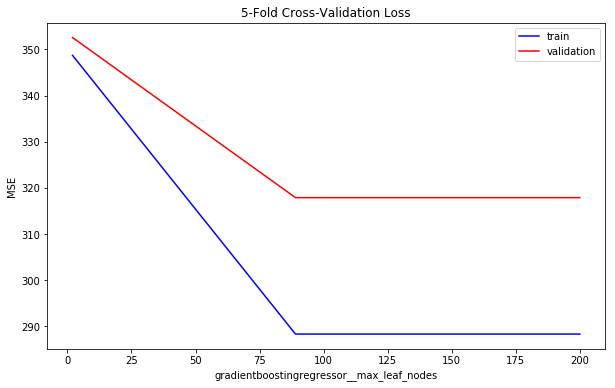

In [19]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.1875],
                                                         'gradientboostingregressor__n_estimators':[250],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[3],
                                                         'gradientboostingregressor__min_samples_leaf':[500], 
                                                         'gradientboostingregressor__min_weight_fraction_leaf':[0], 
                                                         'gradientboostingregressor__max_depth':[3], 
                                                         'gradientboostingregressor__min_impurity_decrease':[0], 
                                                         'gradientboostingregressor__max_features':[None],  
                                                         'gradientboostingregressor__max_leaf_nodes':[2,89,200,None],  
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__max_leaf_nodes') 

#### Tune GradientBoostingRegressor *criterion* hyperparameter
- *criterion* specifies the function to measure the quality of a split. Supported criteria are “friedman_mse” for the mean squared error with improvement score by Friedman, “mse” for mean squared error, and “mae” for the mean absolute error. The default value of “friedman_mse” is generally the best as it can provide a better approximation in some cases.
- *friedman_mse* outperformed *mse*.


scores_train: [ 299.77630695  299.77630695]
scores_val: [ 317.3715812  317.3715812]
tuned optimal hyperparmeter: {'gradientboostingregressor__learning_rate': 0.1875, 'gradientboostingregressor__min_weight_fraction_leaf': 0, 'gradientboostingregressor__max_features': None, 'gradientboostingregressor__subsample': 1, 'gradientboostingregressor__max_leaf_nodes': None, 'gradientboostingregressor__min_samples_leaf': 500, 'gradientboostingregressor__min_samples_split': 3, 'gradientboostingregressor__min_impurity_decrease': 0, 'gradientboostingregressor__max_depth': 3, 'gradientboostingregressor__n_estimators': 250, 'gradientboostingregressor__criterion': 'friedman_mse'}
gridsearch best score: 317.371581204


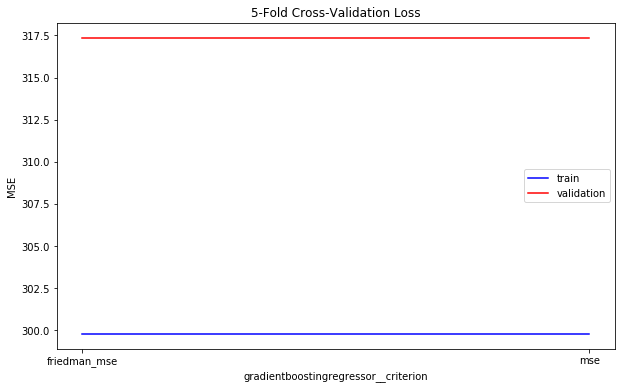

In [20]:
gb_pipe = make_pipeline(SimpleImputer(strategy='median'),GradientBoostingRegressor())
gb_pipe_best = m._tune_hyperparams(model=gb_pipe,params={
                                                         'gradientboostingregressor__learning_rate':[.1875],
                                                         'gradientboostingregressor__n_estimators':[250],
                                                         'gradientboostingregressor__subsample':[1],
                                                         'gradientboostingregressor__min_samples_split':[3],
                                                         'gradientboostingregressor__min_samples_leaf':[500], 
                                                         'gradientboostingregressor__min_weight_fraction_leaf':[0], 
                                                         'gradientboostingregressor__max_depth':[3], 
                                                         'gradientboostingregressor__min_impurity_decrease':[0], 
                                                         'gradientboostingregressor__max_features':[None],  
                                                         'gradientboostingregressor__max_leaf_nodes':[None],  
                                                         'gradientboostingregressor__criterion':['friedman_mse','mse'],  
                                                        },lossfunc='neg_mean_squared_error',
                                   plot_param='gradientboostingregressor__criterion') 